In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
import numba
import seaborn as sns
import sklearn
import sklearn.datasets, sklearn.neighbors, sklearn.tree, sklearn.neural_network, sklearn.model_selection, \
       sklearn.preprocessing, sklearn.decomposition, \
       sklearn.linear_model, sklearn.pipeline, sklearn.metrics
import sklearn_pandas
import pydotplus

%pylab inline
pylab.rcParams['figure.figsize'] = (18, 5)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

np.random.seed(33)

Populating the interactive namespace from numpy and matplotlib


# Read data to a dataframe
Drop 'setosa' it is linearly separable - no fun

,index,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
50,50,7.0,3.2,4.7,1.4,versicolor
51,51,6.4,3.2,4.5,1.5,versicolor
52,52,6.9,3.1,4.9,1.5,versicolor
53,53,5.5,2.3,4.0,1.3,versicolor
...,...,...,...,...,...,...
146,146,6.3,2.5,5.0,1.9,virginica
147,147,6.5,3.0,5.2,2.0,virginica
148,148,6.2,3.4,5.4,2.3,virginica
149,149,5.9,3.0,5.1,1.8,virginica


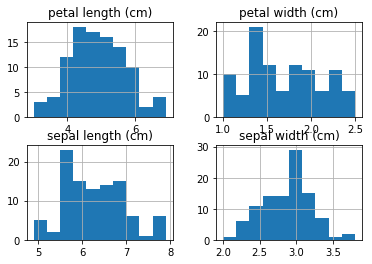

In [2]:
iris = sklearn.datasets.load_iris()

def xy_to_df(X, y, columns, class_names):
    df = pd.DataFrame(columns=columns, data=X)
    df['class'] = class_names[y]
    return df
df = xy_to_df(iris.data, iris.target, iris.feature_names, iris.target_names)
df.reset_index(inplace=True)
df = df[df['class'] != 'setosa']

df.iloc[:,1:].hist()
with pd.option_context('display.max_rows', 9):
    display(df)

# Scale features

[array(['versicolor', 'virginica'], dtype=object)]


,index,seplen,sepwid,petlen,petwid,sepwl,petwl,seppetl,seppetw,class,is_cl
50,50,1.12,0.99,-0.25,-0.65,-0.07,-0.83,1.43,1.29,0.0,0
51,51,0.21,0.99,-0.49,-0.42,0.84,-0.11,0.94,0.89,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
148,148,-0.09,1.59,0.60,1.48,1.87,1.77,-1.08,-0.85,1.0,1
149,149,-0.55,0.39,0.24,0.29,1.02,0.28,-1.01,-0.35,1.0,1


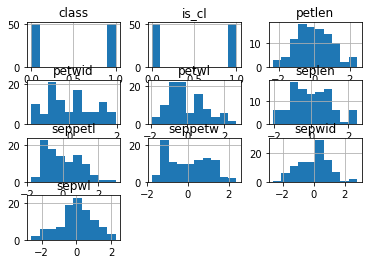

In [3]:
def mapper_inverse_transform(self, df_norm):
    multiouts = [sklearn.preprocessing.label.LabelBinarizer]
    df = pd.DataFrame(index=df_norm.index)
    for orig_cols, scaler, *kw in self.features:
        has_alias = len(kw) > 0 and 'alias' in kw[0]
        orig_cols = orig_cols if type(orig_cols) != str else [orig_cols]
        al = kw[0]['alias'] if has_alias else None
        cols = []
        pref = orig_cols[0] if len(orig_cols) == 1 and al is None else al
        for c in df_norm.columns:
            if pref:
                cols = [c for c in df_norm.columns if c[:len(pref)] == pref and (len(c) == len(pref) or c[len(pref)] == '_')]
            else: 
                cols = [c for c in orig_cols if c in orig_cols]
        for c in orig_cols:
            df[c] = pd.Series()
#         print(orig_cols, cols)
        if scaler is None:
            df[orig_cols] = df_norm[cols].values
            continue
        df[orig_cols] = scaler.inverse_transform(df_norm[cols].values)
    return df
sklearn_pandas.DataFrameMapper.inverse_transform = mapper_inverse_transform

df['sepwl'] = df['sepal width (cm)'] / df['sepal length (cm)']
df['petwl'] = df['petal width (cm)'] / df['petal length (cm)']
df['seppetl'] = df['sepal length (cm)'] / df['petal length (cm)']
df['seppetw'] = df['sepal width (cm)'] / df['petal width (cm)']
class_ordinal_encoder = sklearn.preprocessing.OrdinalEncoder()
mapper = sklearn_pandas.DataFrameMapper([
    ('index', None),
    (['sepal length (cm)'], sklearn.preprocessing.StandardScaler(), {'alias': 'seplen'}),
    (['sepal width (cm)'], sklearn.preprocessing.StandardScaler(), {'alias': 'sepwid'}),
    (['petal length (cm)'], sklearn.preprocessing.StandardScaler(), {'alias': 'petlen'}),
    (['petal width (cm)'], sklearn.preprocessing.StandardScaler(), {'alias': 'petwid'}),
    (['sepwl'], sklearn.preprocessing.StandardScaler()),
    (['petwl'], sklearn.preprocessing.StandardScaler()),
    (['seppetl'], sklearn.preprocessing.StandardScaler()),
    (['seppetw'], sklearn.preprocessing.StandardScaler()),
    (['class'], class_ordinal_encoder),
    (['class'], sklearn.preprocessing.LabelBinarizer(), {'alias': 'is_cl'})
], df_out=True)
df_norm = mapper.fit_transform(df)
print(class_ordinal_encoder.categories_)

df_norm.iloc[:,1:].hist()
with pd.option_context('display.max_rows', 5):
    display(df_norm.round(2))

# Compare features in classes

In [4]:
def compare_features_by_class(df, features, class_col_name='class', aggs={'min': np.min, 'mean': np.mean, 'max': np.max}):
    mi_level0 = np.array(features).repeat(len(aggs))
    mi_level1 = list(aggs.keys()) * len(features)
    mi = pd.MultiIndex.from_arrays([mi_level0, mi_level1], names=['feature', ''])
    pdf = pd.DataFrame(columns=mi, index=df[class_col_name].unique())
    pdf.index.name = class_col_name
    for agg in aggs.keys():
        gr = df[list(features) + [class_col_name]].groupby(class_col_name).agg(aggs[agg])
        pdf.loc[:, pdf.columns.get_level_values(1) == agg] = gr.values
    return pdf

features_to_compare = ['seplen', 'sepwid', 'petlen', 'petwid', 'sepwl', 'petwl', 'seppetl', 'seppetw']
compare_by = {'min': np.min, 'max': np.max}
df_comparison = compare_features_by_class(df_norm, features_to_compare, 'class', aggs=compare_by)

display(df_comparison.round(2))
display(df_norm.iloc[:,1:].corr().round(2))

feature seplen       sepwid       petlen       petwid       sepwl       petwl  \
           min   max    min   max    min   max    min   max   min   max   min   
class                                                                           
0.0      -2.07  1.12  -2.63  1.59  -2.32  0.24  -1.60  0.29 -2.25  2.26 -1.93   
1.0      -2.07  2.48  -2.03  2.80  -0.49  2.43  -0.65  1.95 -2.61  1.87 -1.80   

feature       seppetl       seppetw        
          max     min   max     min   max  
class                                      
0.0      0.73   -0.87  2.98   -0.88  2.39  
1.0      2.67   -1.80  0.43   -1.77  0.27

,seplen,sepwid,petlen,petwid,sepwl,petwl,seppetl,seppetw,class,is_cl
seplen,1.00,0.55,0.83,0.59,-0.38,0.12,-0.34,-0.44,0.49,0.49
sepwid,0.55,1.00,0.52,0.57,0.55,0.40,-0.31,-0.17,0.31,0.31
petlen,0.83,0.52,1.00,0.82,-0.24,0.33,-0.80,-0.74,0.79,0.79
petwid,0.59,0.57,0.82,1.00,0.04,0.80,-0.76,-0.89,0.83,0.83
sepwl,-0.38,0.55,-0.24,0.04,1.00,0.32,-0.02,0.25,-0.15,-0.15
petwl,0.12,0.40,0.33,0.80,0.32,1.00,-0.43,-0.72,0.56,0.56
seppetl,-0.34,-0.31,-0.80,-0.76,-0.02,-0.43,1.00,0.78,-0.78,-0.78
seppetw,-0.44,-0.17,-0.74,-0.89,0.25,-0.72,0.78,1.00,-0.83,-0.83
class,0.49,0.31,0.79,0.83,-0.15,0.56,-0.78,-0.83,1.00,1.00
is_cl,0.49,0.31,0.79,0.83,-0.15,0.56,-0.78,-0.83,1.00,1.00


# Train - test split

In [5]:
def split_df(df, **kwargs):
    train, test = sklearn.model_selection.train_test_split(df.values, **kwargs)
    train_df = pd.DataFrame(columns=df.columns, data=train)
    test_df = pd.DataFrame(columns=df.columns, data=test)
    for col in df.columns:
        train_df[col] = train_df[col].astype(df[col].dtype)
        test_df[col] = test_df[col].astype(df[col].dtype)
    return train_df, test_df
    
# random_state 429
df_train, df_test = split_df(df_norm, test_size=0.2, random_state=0)

inversed_df_test = mapper.inverse_transform(df_test)
inversed_df_test['index'] = inversed_df_test['index'].astype(int)

with pd.option_context('display.max_rows', 5):
    display(df_test)
    display(inversed_df_test)

,index,seplen,sepwid,petlen,petwid,sepwl,petwl,seppetl,seppetw,class,is_cl
0,76,0.815755,-0.217468,-0.129042,-0.653039,-1.037813,-0.958964,0.895955,0.535118,0.0,0
1,136,0.057618,1.594766,0.844858,1.713045,1.684062,1.819256,-1.245248,-1.010584,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
18,83,-0.397263,-0.519507,0.236171,-0.179822,-0.224231,-0.511323,-0.867388,-0.292936,0.0,0
19,58,0.512500,0.084571,-0.372516,-0.889647,-0.449910,-1.142779,1.028949,1.146605,0.0,0


,index,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sepwl,petwl,seppetl,seppetw,class
0,76,6.8,2.8,4.8,1.4,0.411765,0.291667,1.416667,2.000000,versicolor
1,136,6.3,3.4,5.6,2.4,0.539683,0.428571,1.125000,1.416667,virginica
...,...,...,...,...,...,...,...,...,...,...
18,83,6.0,2.7,5.1,1.6,0.450000,0.313725,1.176471,1.687500,versicolor
19,58,6.6,2.9,4.6,1.3,0.439394,0.282609,1.434783,2.230769,versicolor


# Fit and predict using KNeighborsClassifier

In [6]:
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1, weights='distance')

def df_to_xy(df, x_cols, y_cols):
    x = df[x_cols].values
    y = df[y_cols].values
    return x, y

features_for_prediction = features_to_compare #['seplen', 'sepwid', 'petlen', 'petwid']
x_train, y_train = df_to_xy(df_train, features_for_prediction, ['class'])
x_test, y_test = df_to_xy(df_test, features_for_prediction, ['class'])
y_train = y_train.reshape(-1).astype(int)
knn.fit(x_train, y_train)

pred_y_train = knn.predict(x_test)
df_pred = df_test.copy()
df_pred['predicted class'] = pred_y_train
df_pred['correct'] = df_pred['class'] == df_pred['predicted class']
incorrect_pred = df_pred[df_pred['correct'] == False]
incorrect_pred.columns = incorrect_pred.columns.rename('incorrects')
neighbors_ids = knn.kneighbors(x_test[incorrect_pred.index].reshape(len(incorrect_pred), -1), n_neighbors=1)
neighbors_ids = neighbors_ids[1].ravel()
incorrect_neighbors = df_train.loc[neighbors_ids]
incorrect_neighbors.columns = incorrect_neighbors.columns.rename('incorr neighb')

print('correct on train', (y_train == knn.predict(x_train)).sum(), 'of', len(y_train))
with pd.option_context('display.max_rows', 5):
    display(df_pred.round(2))
    print('incorrect predictions', len(incorrect_pred), 'of', len(df_pred['correct']))
    display(incorrect_pred.round(2))
    display(incorrect_neighbors.round(2))

correct on train 80 of 80


,index,seplen,sepwid,petlen,petwid,sepwl,petwl,seppetl,seppetw,class,is_cl,predicted class,correct
0,76,0.82,-0.22,-0.13,-0.65,-1.04,-0.96,0.90,0.54,0.0,0,0,True
1,136,0.06,1.59,0.84,1.71,1.68,1.82,-1.25,-1.01,1.0,1,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,83,-0.40,-0.52,0.24,-0.18,-0.22,-0.51,-0.87,-0.29,0.0,0,1,False
19,58,0.51,0.08,-0.37,-0.89,-0.45,-1.14,1.03,1.15,0.0,0,0,True


incorrect predictions 2 of 20


incorrects,index,seplen,sepwid,petlen,petwid,sepwl,petwl,seppetl,seppetw,class,is_cl,predicted class,correct
16,72,0.06,-1.12,-0.01,-0.42,-1.36,-0.67,-0.07,-0.35,0.0,0,1,False
18,83,-0.40,-0.52,0.24,-0.18,-0.22,-0.51,-0.87,-0.29,0.0,0,1,False


incorr neighb,index,seplen,sepwid,petlen,petwid,sepwl,petwl,seppetl,seppetw,class,is_cl
55,119,-0.40,-2.03,0.11,-0.42,-2.00,-0.79,-0.69,-0.88,1.0,1
73,133,0.06,-0.22,0.24,-0.42,-0.34,-0.91,-0.44,0.18,1.0,1


# Fit and predict using DecisionTreeClassifier

correct on train 80 of 80


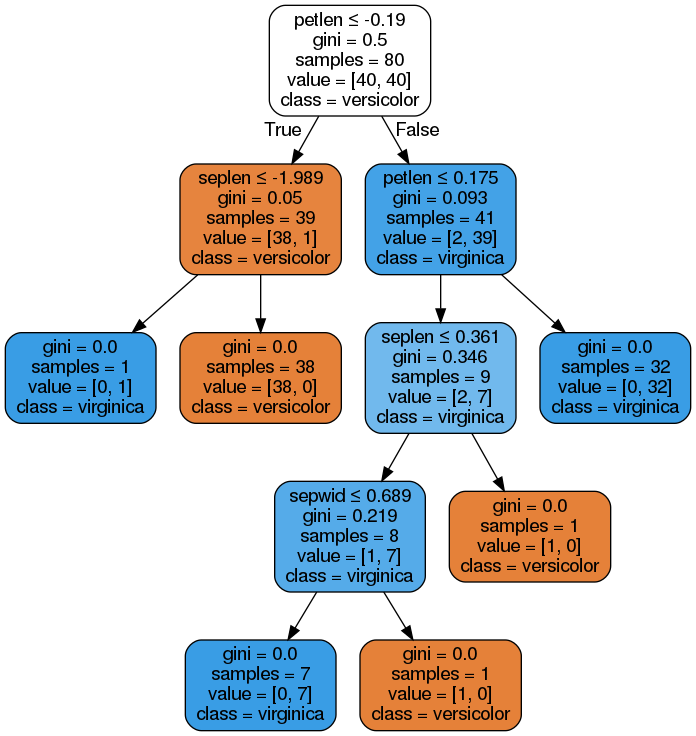

,index,seplen,sepwid,petlen,petwid,sepwl,petwl,seppetl,seppetw,class,is_cl,predicted class,correct
0,76,0.82,-0.22,-0.13,-0.65,-1.04,-0.96,0.90,0.54,0.0,0,0,True
1,136,0.06,1.59,0.84,1.71,1.68,1.82,-1.25,-1.01,1.0,1,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,83,-0.40,-0.52,0.24,-0.18,-0.22,-0.51,-0.87,-0.29,0.0,0,1,False
19,58,0.51,0.08,-0.37,-0.89,-0.45,-1.14,1.03,1.15,0.0,0,0,True


incorrect predictions 3 of 20


incorrects,index,seplen,sepwid,petlen,petwid,sepwl,petwl,seppetl,seppetw,class,is_cl,predicted class,correct
14,57,-2.07,-1.43,-1.96,-1.60,0.62,-0.73,1.40,1.60,0.0,0,1,False
16,72,0.06,-1.12,-0.01,-0.42,-1.36,-0.67,-0.07,-0.35,0.0,0,1,False
18,83,-0.40,-0.52,0.24,-0.18,-0.22,-0.51,-0.87,-0.29,0.0,0,1,False


In [7]:
des_tree = sklearn.tree.DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=0)

features_for_prediction = ['seplen', 'sepwid', 'petlen', 'petwid']
x_train, y_train = df_to_xy(df_train, features_for_prediction, ['class'])
x_test, y_test = df_to_xy(df_test, features_for_prediction, ['class'])
y_train = y_train.reshape(-1).astype(int)
des_tree.fit(x_train, y_train)

# def test_pred(clf, df, features, targets):
#     x, y = df_to_xy(df, features, targets)
#     pred_y = clf.predict(x_test)
#     df = df.copy()
#     pred_cols = ['pred ' + col for col in targets]
#     for col in pred_cols: df[col] = np.nan
#     df[pred_cols] = pred_y
#     display(df[pred_cols], df[targets])
#     df['correct'] = df[pred_cols] == df[targets]
#     incorrect_pred = df[df['correct'] == False]
#     incorrect_pred.columns = incorrect_pred.columns.rename('incorrects')
#     return df, incorrect_pred
    
# df_pred, incorrect_pred = test_pred(des_tree, df_test, features_for_prediction, ['class'])
    
pred_y_train = des_tree.predict(x_test)
df_pred = df_test.copy()
df_pred['predicted class'] = pred_y_train
df_pred['correct'] = df_pred['class'] == df_pred['predicted class']
incorrect_pred = df_pred[df_pred['correct'] == False]
incorrect_pred.columns = incorrect_pred.columns.rename('incorrects')

graphviz_options = {'filled': True, 'rounded': True, 'special_characters': True}
dot_data = sklearn.tree.export_graphviz(des_tree, out_file=None, feature_names=features_for_prediction, class_names=class_ordinal_encoder.categories_[0], **graphviz_options)  
graph = pydotplus.graph_from_dot_data(dot_data)


print('correct on train', (y_train == des_tree.predict(x_train)).sum(), 'of', len(y_train))
display(Image(graph.create_png()))
with pd.option_context('display.max_rows', 5):
    display(df_pred.round(2))
    print('incorrect predictions', len(incorrect_pred), 'of', len(df_pred['correct']))
    display(incorrect_pred.round(2))

# Let's try with a neural network

In [8]:
mlp = sklearn.neural_network.MLPClassifier(activation='tanh', early_stopping=False, max_iter=1000, 
                                           learning_rate='adaptive', hidden_layer_sizes=(10,10))

features_for_prediction = ['seplen', 'sepwid', 'petlen', 'petwid']
x_train, y_train = df_to_xy(df_train, features_for_prediction, ['class'])
x_test, y_test = df_to_xy(df_test, features_for_prediction, ['class'])
y_train = y_train.reshape(-1).astype(int)
mlp.fit(x_train, y_train)
    
pred_y_train = mlp.predict(x_test)
df_pred = df_test.copy()
df_pred['predicted class'] = pred_y_train
df_pred['correct'] = df_pred['class'] == df_pred['predicted class']
incorrect_pred = df_pred[df_pred['correct'] == False]
incorrect_pred.columns = incorrect_pred.columns.rename('incorrects')

print(mlp)
print('correct on train', (y_train == mlp.predict(x_train)).sum(), 'of', len(y_train))
with pd.option_context('display.max_rows', 5):
    display(df_pred.round(2))
    print('incorrect predictions', len(incorrect_pred), 'of', len(df_pred['correct']))
    display(incorrect_pred.round(2))

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
correct on train 79 of 80


,index,seplen,sepwid,petlen,petwid,sepwl,petwl,seppetl,seppetw,class,is_cl,predicted class,correct
0,76,0.82,-0.22,-0.13,-0.65,-1.04,-0.96,0.90,0.54,0.0,0,0,True
1,136,0.06,1.59,0.84,1.71,1.68,1.82,-1.25,-1.01,1.0,1,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,83,-0.40,-0.52,0.24,-0.18,-0.22,-0.51,-0.87,-0.29,0.0,0,1,False
19,58,0.51,0.08,-0.37,-0.89,-0.45,-1.14,1.03,1.15,0.0,0,0,True


incorrect predictions 2 of 20


incorrects,index,seplen,sepwid,petlen,petwid,sepwl,petwl,seppetl,seppetw,class,is_cl,predicted class,correct
16,72,0.06,-1.12,-0.01,-0.42,-1.36,-0.67,-0.07,-0.35,0.0,0,1,False
18,83,-0.40,-0.52,0.24,-0.18,-0.22,-0.51,-0.87,-0.29,0.0,0,1,False


## No classifier can classify samples 72, 83 correctly; let's take a closer look
## Maybe we can come up with some rule based classifier


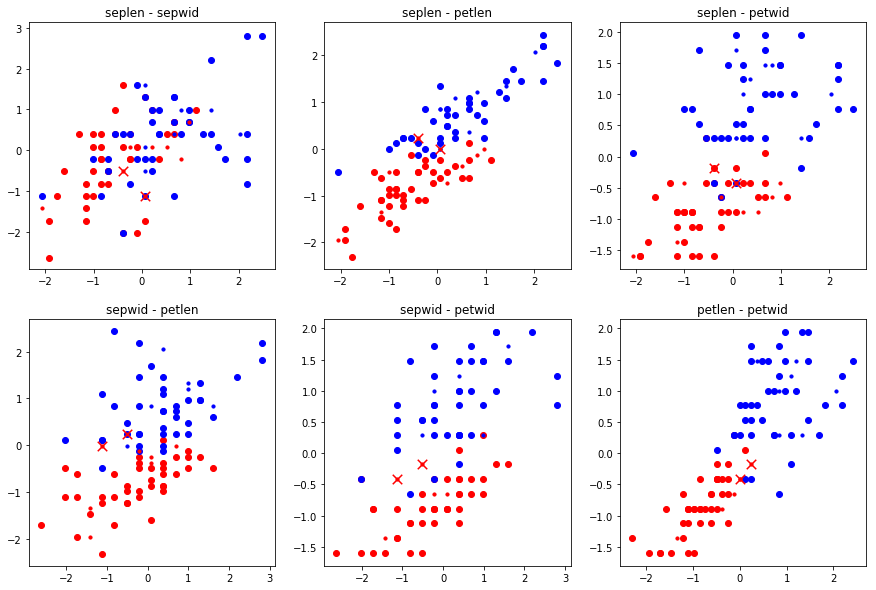

In [9]:
df_ve = df_train[df_train['class'] == 0]
df_vi = df_train[df_train['class'] == 1]
df_ve_test = df_test[df_test['class'] == 0]
df_vi_test = df_test[df_test['class'] == 1]

def scatter_pairwise(fs, df1, df2, dfx, df3, df4):
    ffs = [(f1, f2) for i, f1 in enumerate(fs) for f2 in fs[i+1:]]
    size = np.array([2, int(np.ceil(len(ffs) / 2))])
    fig, axs = plt.subplots(*size, figsize=size[::-1] * 5)
    for (f1, f2), ax in zip(ffs, axs.ravel()):
        ax.scatter(df1[f1], df1[f2], c='red')
        ax.scatter(df2[f1], df2[f2], c='blue')
        ax.scatter(df3[f1], df3[f2], c='red', s=10)
        ax.scatter(df4[f1], df4[f2], c='blue', s=10)
        ax.scatter(dfx[f1], dfx[f2], c='red', marker='x', s=90)
        ax.set_title('{} - {}'.format(f1, f2))
        
scatter_pairwise(['seplen', 'sepwid', 'petlen', 'petwid'], df_ve, df_vi, incorrect_pred, df_ve_test, df_vi_test)

## Filter out some blue dots
So as it turns out these 2 samples really look more similar to 'virginica' (blue).
Too few data samples to come up with a definite rule to distinguish them.
But reds always have petwid < 0.25, let's see how flowers with petwid < 0.25 are distributed. Then maybe we can filter out more blue dots by some other feature.
Correlation table at 'Compare features in classes' also suggests that 'petwid' is a good predictor

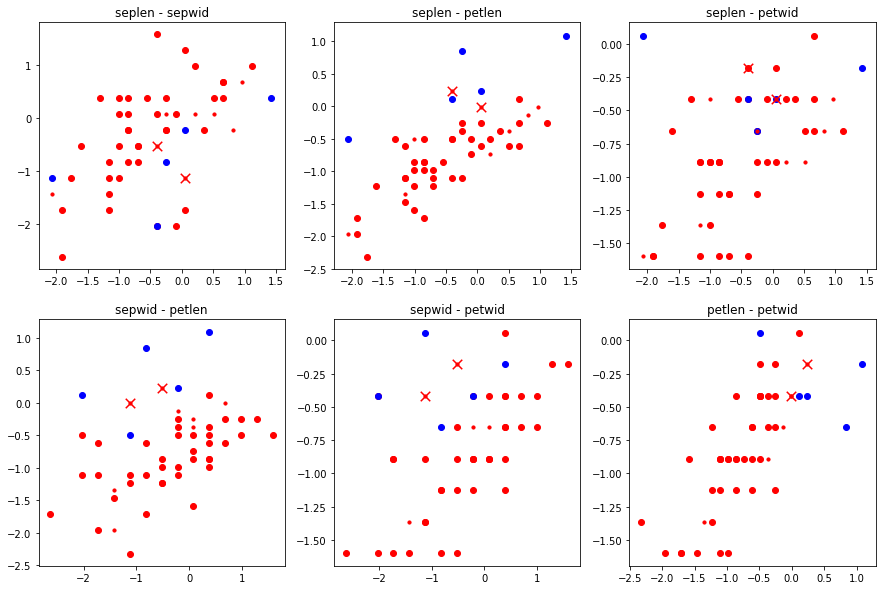

In [10]:
df_ve025 = df_ve[df_ve['petwid'] < 0.25 ]
df_vi025 = df_vi[df_vi['petwid'] < 0.25 ]
df_ve_test025 = df_ve_test[df_ve_test['petwid'] < 0.25 ]
df_vi_test025 = df_vi_test[df_vi_test['petwid'] < 0.25 ]

scatter_pairwise(['seplen', 'sepwid', 'petlen', 'petwid'], 
                 df_ve025, df_vi025, incorrect_pred, df_ve_test025, df_vi_test025)

## Still blue dots scattered all over the place, there is nothing we can do.
The complicated decision tree can be made but that would be overfitting to the data. Some virginicas are practically indistinguishable from versicolors.